# G27
Dave Brunner

In [150]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import tensor


def read_words(filename):
    with open(filename, 'r', encoding='ISO-8859-1') as file:
        words = file.readlines()
        content = [x.strip() for x in words]
        content = [x for x in content if x and x[0] != ';']
        return content

In [151]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [152]:
positive_words = read_words('data/positive-words.txt')
negative_words = read_words('data/negative-words.txt')

In [153]:
print(f'Number of positive words: {len(positive_words)}')
print(f'Number of negative words: {len(negative_words)}')

Number of positive words: 2006
Number of negative words: 4783


In [154]:
print(positive_words[:10])

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']


In [155]:
print(negative_words[:10])

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [156]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf−8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [157]:
 # off−line dictionary for glove 21 
word_dict = load_glove_embeddings('data/glove.6B.50d.txt')
word = 'tree'
vector = word_dict[word]  # if word is in word_dict
print(vector)

[ 0.62231   1.1986   -0.014116  0.20125   0.69419   0.12068  -0.90399
 -1.4023    0.43357  -0.48537  -0.4645    0.15756   0.54261  -0.32467
 -0.025646  0.45742   0.16561   0.18819   0.062099 -0.86418  -1.0425
 -0.81157   0.3126   -0.20279   0.55734  -0.28634  -0.14874   1.0098
  0.25041  -0.53195   2.3793   -0.76966  -0.63219   0.3203    0.15072
  0.23326  -0.26254  -0.29461   0.7671   -0.11577  -0.68129  -0.65413
 -0.58914   0.24684   1.5904    0.33025   0.41513  -1.7468    0.82453
 -1.0886  ]


Prepare the data

In [158]:
train_size = 3000

X, Y = [], []
i = 0

for word in positive_words:
    try:
        X.append(word_dict[word])
        Y.append(1)
    except KeyError as e:
        pass

for word in negative_words:
    try:
        X.append(word_dict[word])
        Y.append(0)
    except KeyError as e:
        pass

# shuffle
np.random.seed(0)
perm = np.random.permutation(len(X))
X = [X[i] for i in perm]
Y = [Y[i] for i in perm]


train_X = X[:train_size]
train_Y = Y[:train_size]

test_X = X[train_size:]
test_Y = Y[train_size:]

# convert to tensor
train_X = tensor(np.array(train_X)).to(device)
test_X = tensor(np.array(test_X)).to(device)
train_Y = tensor(np.array(train_Y), dtype=torch.float32).to(device)
test_Y = tensor(np.array(test_Y), dtype=torch.float32).to(device)

In [159]:
print(f'Mean of train_Y: {train_Y.mean()}')
print(f'Mean of test_Y: {test_Y.mean()}')

Mean of train_Y: 0.3016666769981384
Mean of test_Y: 0.3051266372203827


In [160]:
print(f'train_X: {train_X.shape}')
print(f'train_Y: {train_Y.shape}')
print(f'test_X:  {test_X.shape}')
print(f'test_Y:  {test_Y.shape}')
print(train_Y[0])

train_X: torch.Size([3000, 50])
train_Y: torch.Size([3000])
test_X:  torch.Size([3238, 50])
test_Y:  torch.Size([3238])
tensor(0., device='mps:0')


In [161]:
def make_train_loader(X, Y, batch_size):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [162]:
n_input_features = train_X.shape[1]

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_input_features, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [163]:
def train_eval(model, optimizer, criterion, n_epochs, train_loader, test_loader):
    train_acc_hist, test_acc_hist = [], []
    train_loss_hist, test_loss_hist = [], []

    for epoch in range(n_epochs):
        train_acc, train_loss = 0, 0
        for X, Y in train_loader:
            optimizer.zero_grad()
            Y_hat = model(X).view(-1)
            # Y_hat = Y_hat.round()
            loss = criterion(Y_hat, Y)
            loss.backward()
            optimizer.step()

            train_acc += (Y_hat.round() == Y).float().mean().to('cpu')
            train_loss += loss.item()

        train_acc_hist.append(train_acc / len(train_loader))
        train_loss_hist.append(train_loss / len(train_loader))

        with torch.no_grad():
            for X, Y in test_loader:
                Y_hat = model(X).view(-1)
                loss = criterion(Y_hat, Y)
            test_acc_hist.append((Y_hat.round() == Y).float().mean().to('cpu'))
            test_loss_hist.append(loss.item())

        print(f'Epoch {epoch + 1}/{n_epochs}, Train Acc: {train_acc_hist[-1]:.4f}, Test Acc: {test_acc_hist[-1]:.4f}'
              f', Train Loss: {train_loss_hist[-1]:.4f}, Test Loss: {test_loss_hist[-1]:.4f}')
    return {'train_acc': train_acc_hist, 'test_acc': test_acc_hist, 'train_loss': train_loss_hist,
            'test_loss': test_loss_hist}

In [164]:
def plot_history(history):
    plt.figure(1, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [165]:
batch_size = 32
train_loader = make_train_loader(train_X, train_Y, batch_size)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_X, test_Y), batch_size=len(test_X), shuffle=False)

Epoch 1/10, Train Acc: 0.7954, Test Acc: 0.8916, Train Loss: 0.1397, Test Loss: 0.0861
Epoch 2/10, Train Acc: 0.8931, Test Acc: 0.8867, Train Loss: 0.0846, Test Loss: 0.0855
Epoch 3/10, Train Acc: 0.8967, Test Acc: 0.8857, Train Loss: 0.0793, Test Loss: 0.0860
Epoch 4/10, Train Acc: 0.9059, Test Acc: 0.8839, Train Loss: 0.0732, Test Loss: 0.0850
Epoch 5/10, Train Acc: 0.9116, Test Acc: 0.8851, Train Loss: 0.0696, Test Loss: 0.0858
Epoch 6/10, Train Acc: 0.9243, Test Acc: 0.8796, Train Loss: 0.0619, Test Loss: 0.0877
Epoch 7/10, Train Acc: 0.9315, Test Acc: 0.8820, Train Loss: 0.0576, Test Loss: 0.0897
Epoch 8/10, Train Acc: 0.9404, Test Acc: 0.8792, Train Loss: 0.0515, Test Loss: 0.0933
Epoch 9/10, Train Acc: 0.9474, Test Acc: 0.8780, Train Loss: 0.0470, Test Loss: 0.0932
Epoch 10/10, Train Acc: 0.9551, Test Acc: 0.8777, Train Loss: 0.0419, Test Loss: 0.0945


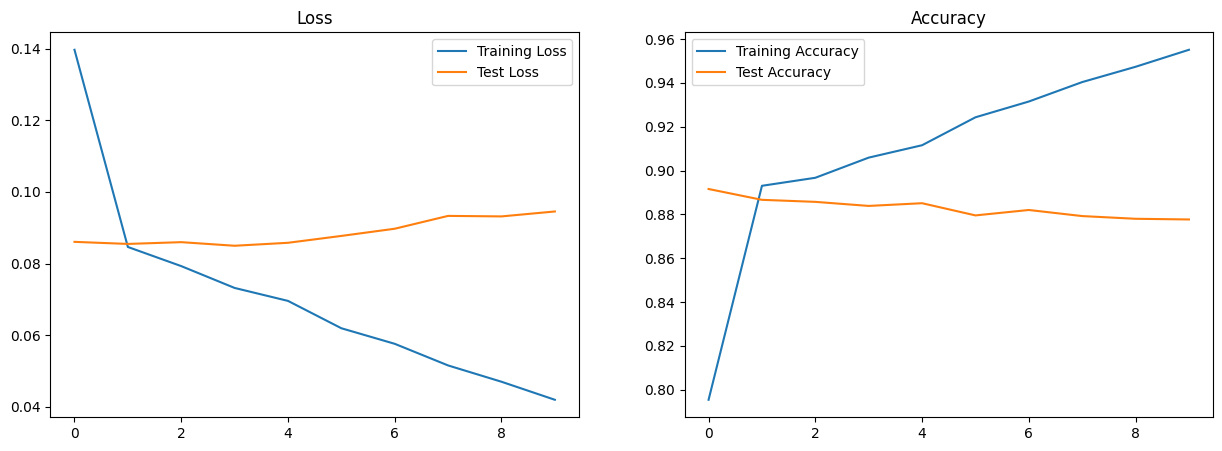

In [166]:
n_epochs = 10
mlp = MLP().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

history = train_eval(mlp, optimizer, criterion, n_epochs, train_loader, test_loader)
plot_history(history)

Epoch 1/10, Train Acc: 0.7436, Test Acc: 0.8768, Train Loss: 0.2957, Test Loss: 0.1580
Epoch 2/10, Train Acc: 0.8823, Test Acc: 0.8857, Train Loss: 0.1305, Test Loss: 0.1231
Epoch 3/10, Train Acc: 0.8911, Test Acc: 0.8857, Train Loss: 0.1147, Test Loss: 0.1197
Epoch 4/10, Train Acc: 0.8959, Test Acc: 0.8833, Train Loss: 0.1085, Test Loss: 0.1203
Epoch 5/10, Train Acc: 0.9003, Test Acc: 0.8814, Train Loss: 0.1030, Test Loss: 0.1199
Epoch 6/10, Train Acc: 0.9060, Test Acc: 0.8820, Train Loss: 0.0986, Test Loss: 0.1198
Epoch 7/10, Train Acc: 0.9086, Test Acc: 0.8848, Train Loss: 0.0971, Test Loss: 0.1179
Epoch 8/10, Train Acc: 0.9123, Test Acc: 0.8814, Train Loss: 0.0922, Test Loss: 0.1204
Epoch 9/10, Train Acc: 0.9141, Test Acc: 0.8839, Train Loss: 0.0888, Test Loss: 0.1190
Epoch 10/10, Train Acc: 0.9161, Test Acc: 0.8786, Train Loss: 0.0867, Test Loss: 0.1203


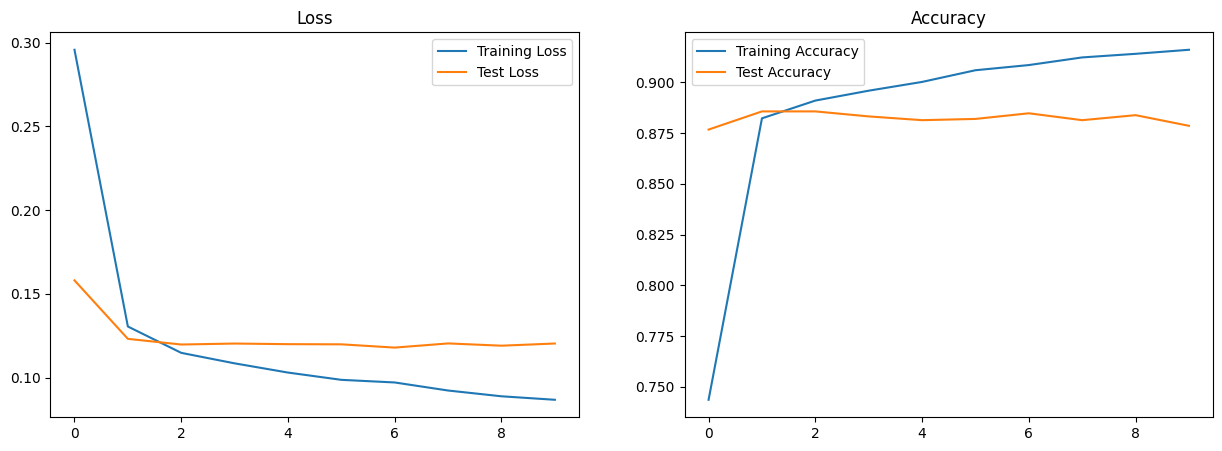

In [167]:
n_epochs = 10
mlp = MLP().to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

history = train_eval(mlp, optimizer, criterion, n_epochs, train_loader, test_loader)
plot_history(history)

Epoch 1/10, Train Acc: 0.7982, Test Acc: 0.8854, Train Loss: 0.0707, Test Loss: 0.0443
Epoch 2/10, Train Acc: 0.8908, Test Acc: 0.8879, Train Loss: 0.0428, Test Loss: 0.0421
Epoch 3/10, Train Acc: 0.8995, Test Acc: 0.8820, Train Loss: 0.0398, Test Loss: 0.0428
Epoch 4/10, Train Acc: 0.9069, Test Acc: 0.8873, Train Loss: 0.0370, Test Loss: 0.0421
Epoch 5/10, Train Acc: 0.9189, Test Acc: 0.8811, Train Loss: 0.0344, Test Loss: 0.0429
Epoch 6/10, Train Acc: 0.9243, Test Acc: 0.8867, Train Loss: 0.0312, Test Loss: 0.0428
Epoch 7/10, Train Acc: 0.9340, Test Acc: 0.8820, Train Loss: 0.0282, Test Loss: 0.0454
Epoch 8/10, Train Acc: 0.9392, Test Acc: 0.8842, Train Loss: 0.0263, Test Loss: 0.0436
Epoch 9/10, Train Acc: 0.9475, Test Acc: 0.8805, Train Loss: 0.0226, Test Loss: 0.0457
Epoch 10/10, Train Acc: 0.9564, Test Acc: 0.8802, Train Loss: 0.0202, Test Loss: 0.0460


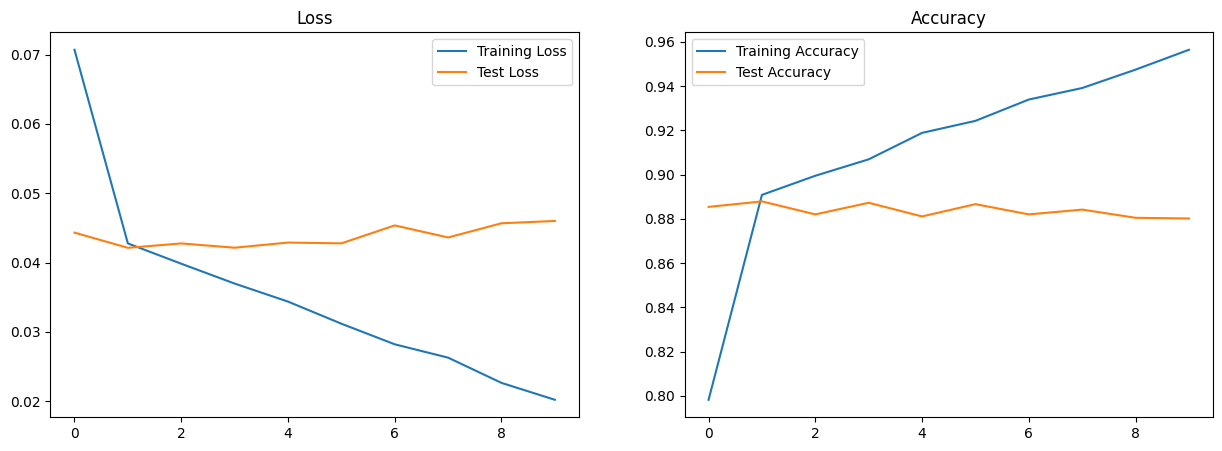

In [168]:
n_epochs = 10
mlp = MLP().to(device)
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

history = train_eval(mlp, optimizer, criterion, n_epochs, train_loader, test_loader)
plot_history(history)

Epoch 1/10, Train Acc: 0.7959, Test Acc: 0.8851, Train Loss: 0.4243, Test Loss: 0.2915
Epoch 2/10, Train Acc: 0.8902, Test Acc: 0.8811, Train Loss: 0.2807, Test Loss: 0.2881
Epoch 3/10, Train Acc: 0.8967, Test Acc: 0.8845, Train Loss: 0.2606, Test Loss: 0.2856
Epoch 4/10, Train Acc: 0.9012, Test Acc: 0.8833, Train Loss: 0.2452, Test Loss: 0.2852
Epoch 5/10, Train Acc: 0.9133, Test Acc: 0.8830, Train Loss: 0.2289, Test Loss: 0.2832
Epoch 6/10, Train Acc: 0.9197, Test Acc: 0.8814, Train Loss: 0.2089, Test Loss: 0.2921
Epoch 7/10, Train Acc: 0.9289, Test Acc: 0.8743, Train Loss: 0.1902, Test Loss: 0.3018
Epoch 8/10, Train Acc: 0.9317, Test Acc: 0.8684, Train Loss: 0.1764, Test Loss: 0.3286
Epoch 9/10, Train Acc: 0.9465, Test Acc: 0.8737, Train Loss: 0.1529, Test Loss: 0.3283
Epoch 10/10, Train Acc: 0.9514, Test Acc: 0.8715, Train Loss: 0.1386, Test Loss: 0.3472


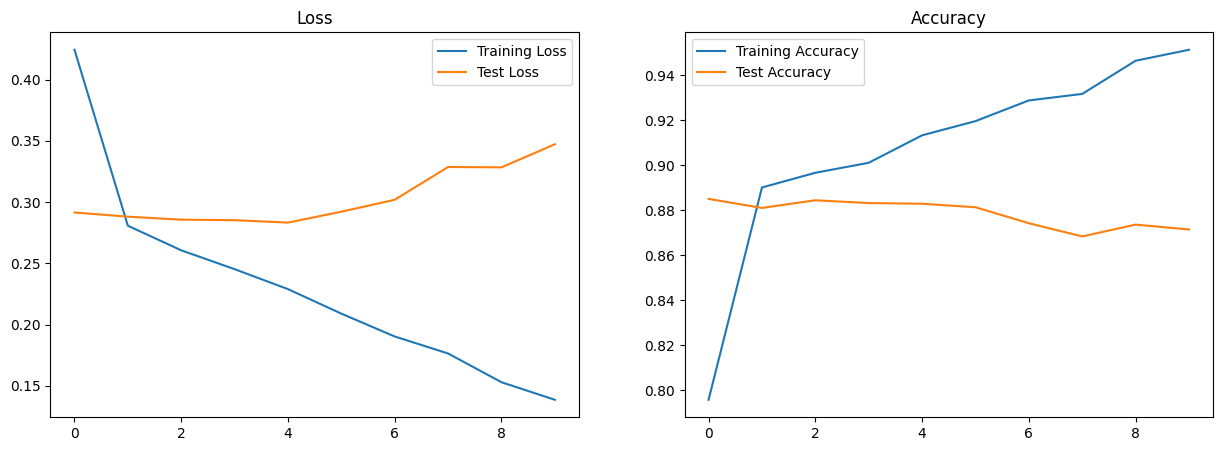

In [169]:
n_epochs = 10
mlp = MLP().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

history = train_eval(mlp, optimizer, criterion, n_epochs, train_loader, test_loader)
plot_history(history)

I tried different types of loss functions. The BinaryCrossEntropy, MSE, SmoothL1 performaed similar with an accuracy on the train set of 0.95 and on the test set of 0.87.

In [170]:
pos_list = ['rainbow', 'health', 'family']
neg_list = ['war', 'hungry', 'thirsty']

custom_pos_word = tensor(np.array([word_dict[word] for word in pos_list])).to(device)
custom_neg_word = tensor(np.array([word_dict[word] for word in neg_list])).to(device)

In [177]:
@torch.inference_mode() 
def predict(model, data):
    # Put the model in eval mode, which disables training specific behaviour.
    model.eval()
    output = model(data)
    return output

print('Positive words:')
for word, input in zip(pos_list, custom_pos_word):
    out = predict(mlp, input)
    print(f'{word}: {out.item():.4f} -> {out.round().item()}')
print('------------------\nNegative words:')
for word, input in zip(neg_list, custom_neg_word):
    out = predict(mlp, input)
    print(f'{word}: {out.item():.4f} -> {out.round().item()}')

Positive words:
rainbow: 0.4538 -> 0.0
health: 0.8903 -> 1.0
family: 0.6936 -> 1.0
------------------
Negative words:
war: 0.0104 -> 0.0
hungry: 0.0688 -> 0.0
thirsty: 0.2411 -> 0.0


The negative word are all classified correctly and quite confidently. So the performance on these 3 neg word is good.
With the positive word 'rainbow' and 'family' the model is not that confident and is close to the decision boundary (0.5).
It even missclassifies the word 'rainbow' as negative. With the word 'health' its more confident, that it is positive.
